
# Week 3 - Clustering & Topic Modeling

This week, we take a text corpus that we have developed, and we first break it into discrete document chunks through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of content clustering called topic modeling. This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. Finally, we will consider how to construct models that take document cluster and topic loading as predictive features.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [2]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'description', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [3]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [4]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,category,source_file,text
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ..."
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom"
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not..."
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [5]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [6]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [7]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [8]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [9]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [10]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.046688020755456),
 ('certain', 0.1589865268627092),
 ('apple', 0.22685454684169398),
 ('13', 0.1411362504801527),
 ('rgb', 0.1817286448065436),
 ('monitors', 0.1619412292430009),
 ('there', 0.0749569030656185),
 ('has', 0.07484299310086841),
 ('been', 0.095991006908172),
 ('problem', 0.18819404816424326),
 ('with', 0.05464092321093494),
 ('the', 0.1109950967372947),
 ('high', 0.12601141569529475),
 ('voltage', 0.19706119834212132),
 ('capasitor', 0.242206441914102),
 ('knows', 0.16299450361806797),
 ('about', 0.15540750198460515),
 ('this', 0.05749878121929968),
 ('and', 0.04330392033255178),
 ('is', 0.04793741654764163)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [11]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [12]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
5       What is the value of an SE (HDFD) 4/20?\n\n-David
6       \n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7       \n\n\n    Nope. The Apple 16" monitor does not...
8       \n\nIs it a hidden option?  I'm using PowerStr...
9       \n\n\nThe previous article referred to the fac...
10      \n\n\n    Yes. That is exactly what it means. ...
11      I saw once an article about a new line of Macs...
12      So, will it be possible to have a NuBus or PDS...
13      \n\n\nWho knows... I just quoted what was "wri...
14      \n\nI also returned PB memory last summer for ...
15      \n\nI think all Powerbooks use the same 2 Meg ...
16      A question in general about displaying NTSC th...
17      The li

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [13]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [14]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [15]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [16]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [17]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'base', 'brier_score_loss', 'calinski_harabaz_score', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_log_error', 'median_absolute_error', 'mutual_info_score', 'normalized_mutual_info_score', 'pairwise', 'pairwise_distances', 'pairwise_distances_argmin', 'pairwise_distances_argmin_min', 'pairwise_fast', 'pairwise_kernels', 'precision_recall_cur

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [18]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,category,source_file,text,kmeans_predictions
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ...",3
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...,3
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...,3
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom",3
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...,3
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David,3
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,3
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not...",3
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...,3
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...,3


We can also look at the distinguishing features in each cluster:

In [19]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 window
 server
 use
 motif
 using
 widget
 program
 application
 code
 like


Cluster 1:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 interested
 price
 email


Cluster 2:
 car
 cars
 engine
 like
 just
 good
 think
 don
 oil
 dealer


Cluster 3:
 know
 thanks
 mac
 just
 does
 drive
 apple
 like
 don
 new




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [20]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [21]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [22]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

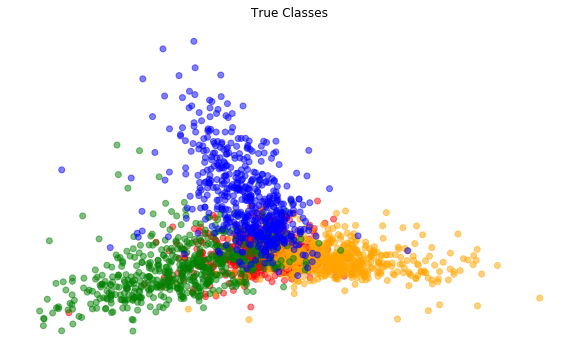

In [23]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

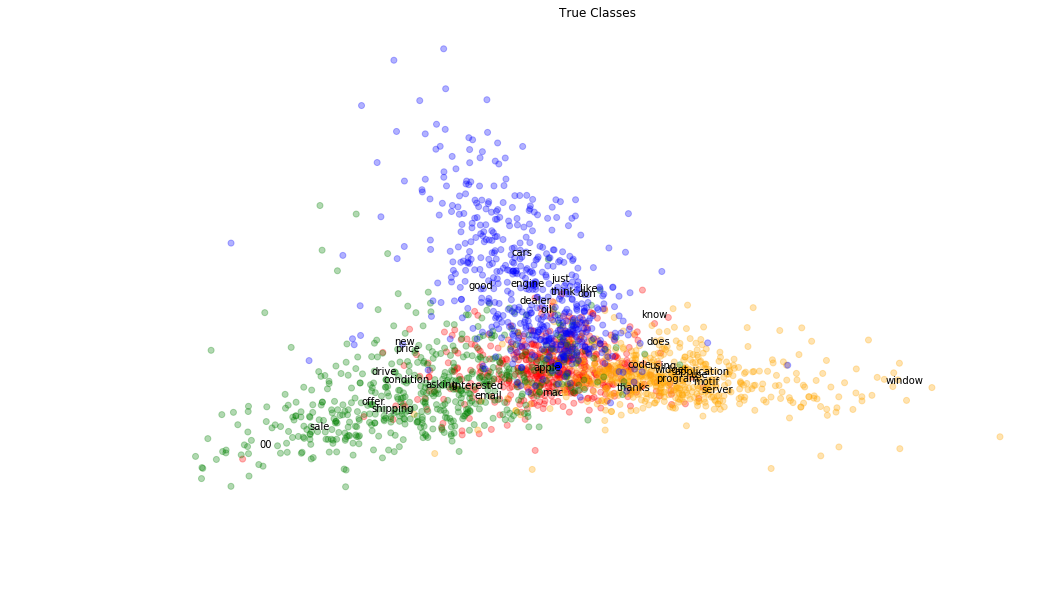

In [24]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [25]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

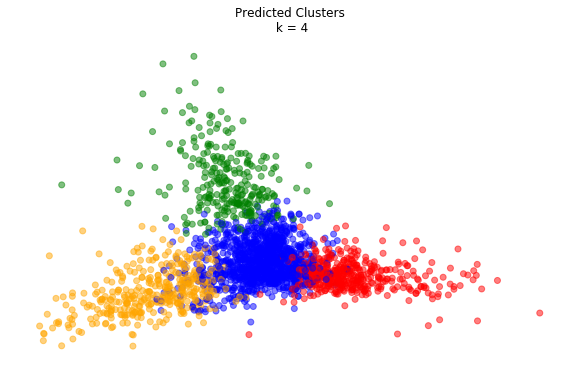

In [26]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [27]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [28]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters

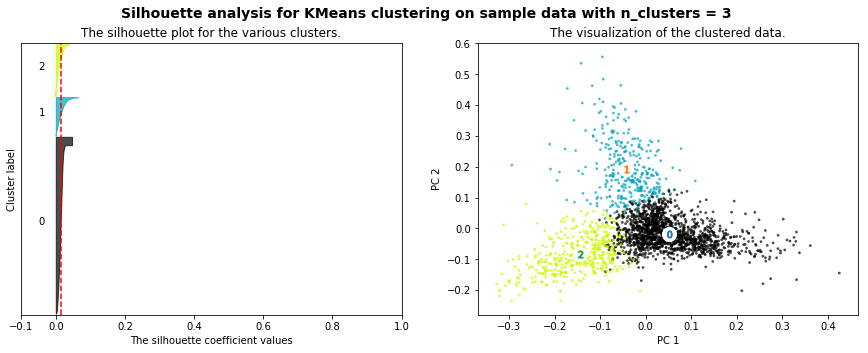

For n_clusters = 3, The average silhouette_score is : 0.014


In [29]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

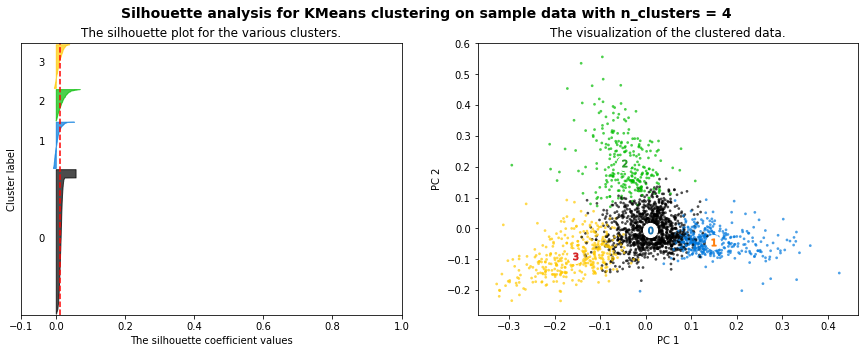

For n_clusters = 4, The average silhouette_score is : 0.012


In [30]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

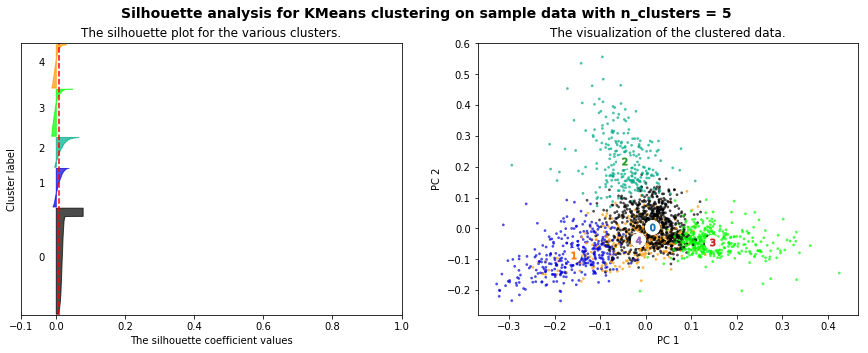

For n_clusters = 5, The average silhouette_score is : 0.010


In [31]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

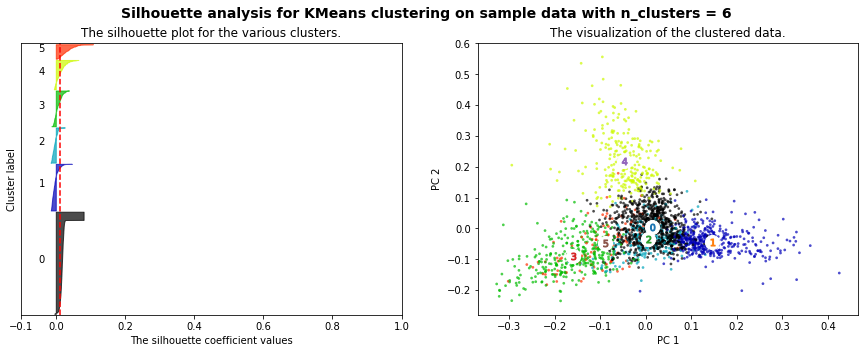

For n_clusters = 6, The average silhouette_score is : 0.011


In [32]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [33]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [34]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [35]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [36]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [37]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [38]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

And visualize:

In [39]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

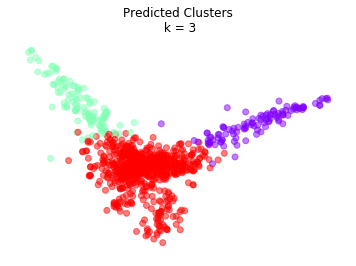

In [40]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters; with Silhouette analysis or maybe some of the metric although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [41]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
5,5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy13.txt,raw/Kennedy/01Aug2006Kennedy13.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
6,6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy14.txt,raw/Kennedy/01Aug2006Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
7,7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy5.txt,raw/Kennedy/01Aug2007Kennedy5.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,2
8,8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy6.txt,raw/Kennedy/01Aug2007Kennedy6.txt,FOR IMMEDIATE RELEASE Rachel Racus...,Kennedy,1
9,9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy7.txt,raw/Kennedy/01Aug2007Kennedy7.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,1


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora?

In [42]:
#First, I load my data. Like last weeks, this is a dataset that contains statements that were made in group 
#discussions on social inequality. However, these discussions were divided into topical sections and so I take 150
#random statements that were made during one of the following sections: Immigration, Gender, Labor Market, Economic
#Inequality, or Generations. I thus know the "true" clustering of these elements and can therefore assess how well
#different cluster approaches are doing in approximatig this structure.

discussions = pandas.read_csv("../data/talking/talking.csv")
discussions = discussions.dropna(axis=0, how='any')
discussions[:4]

,Unnamed: 0,Statement,topic,wordcount,charcount
0,1,I also think get the immigrants jobs as soon ...,Immigration,37,225
1,2,I dont necessarily believe everyone will get ...,Immigration,44,225
2,3,"Regarding immigration, there will be more. We...",Immigration,41,225
3,4,Yeah. Just to maintain skills. You spend 15...,Gender,41,225


In [43]:
#Next, I do some adjustments to my dataframe. I throw out words that appear in only one document or in more than
#50% of the documents. I also remove stopwords.
targetDF = discussions
textColumn = 'Statement'
numCategories = 5

discussionTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=2, stop_words='english', norm='l2')
discussionTFVects = discussionTFVectorizer.fit_transform(targetDF[textColumn])

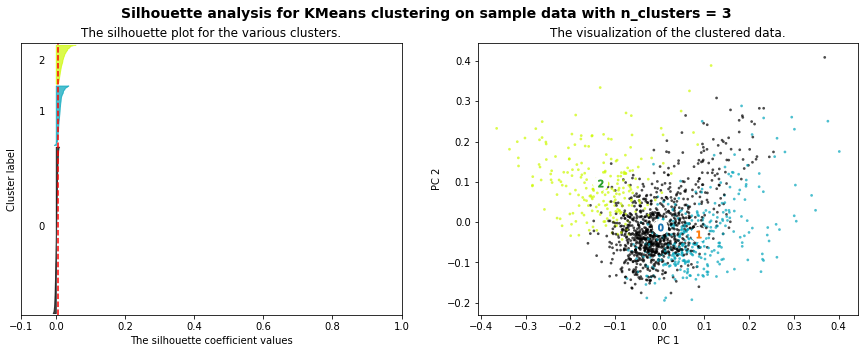

For n_clusters = 3, The average silhouette_score is : 0.006


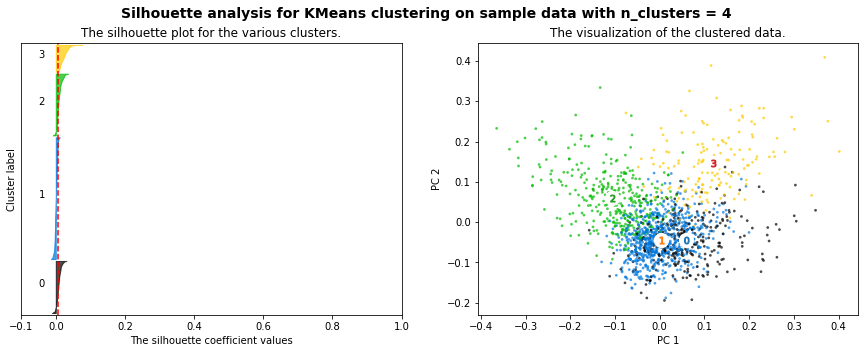

For n_clusters = 4, The average silhouette_score is : 0.006


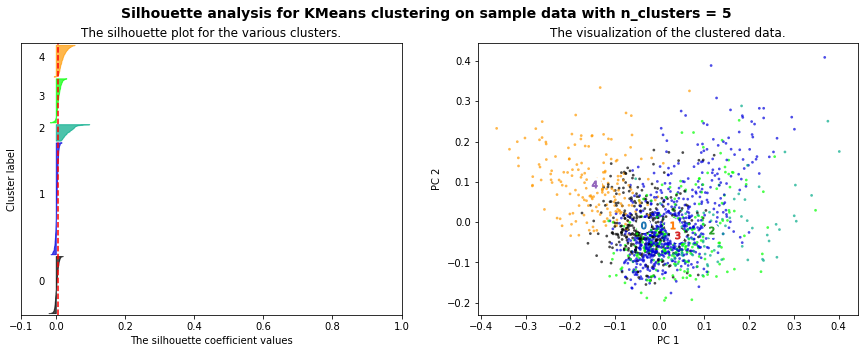

For n_clusters = 5, The average silhouette_score is : 0.007


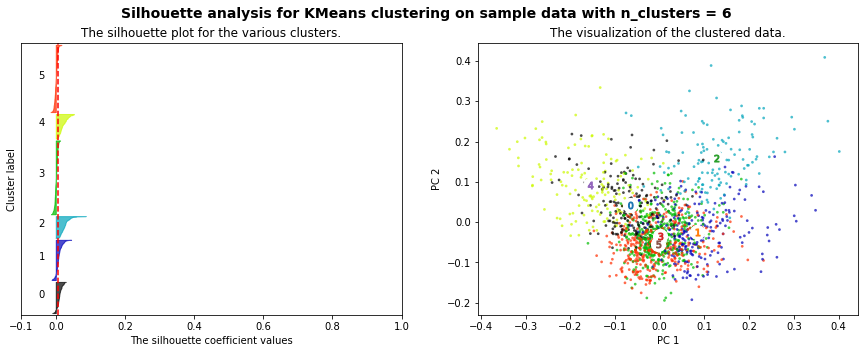

For n_clusters = 6, The average silhouette_score is : 0.007


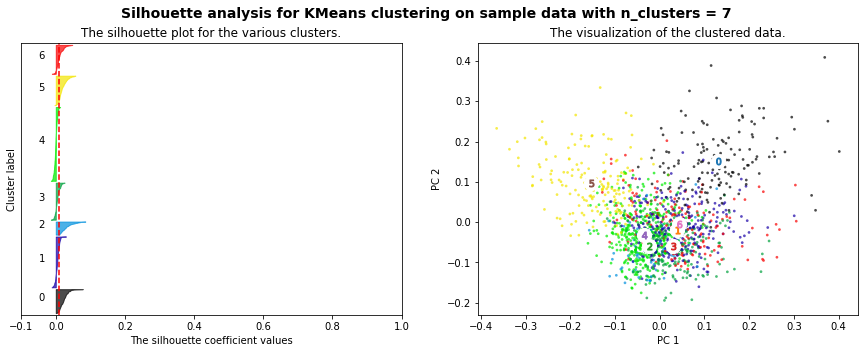

For n_clusters = 7, The average silhouette_score is : 0.008


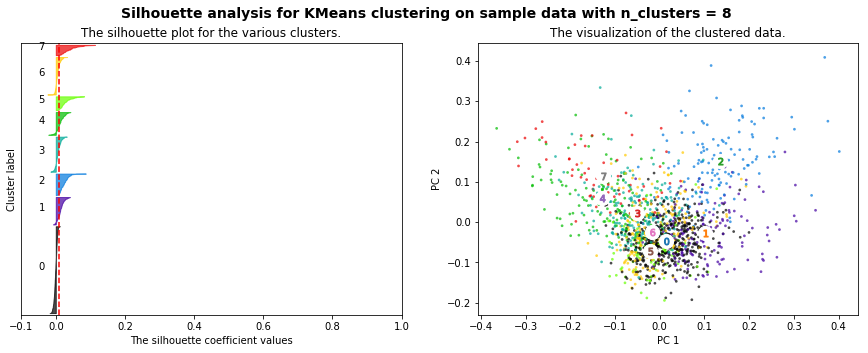

For n_clusters = 8, The average silhouette_score is : 0.008


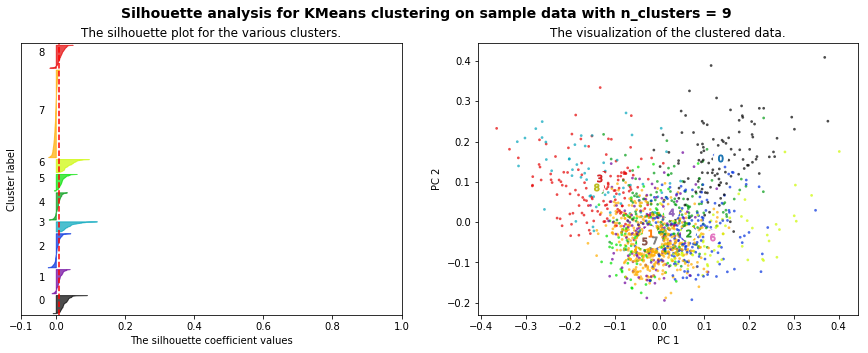

For n_clusters = 9, The average silhouette_score is : 0.009


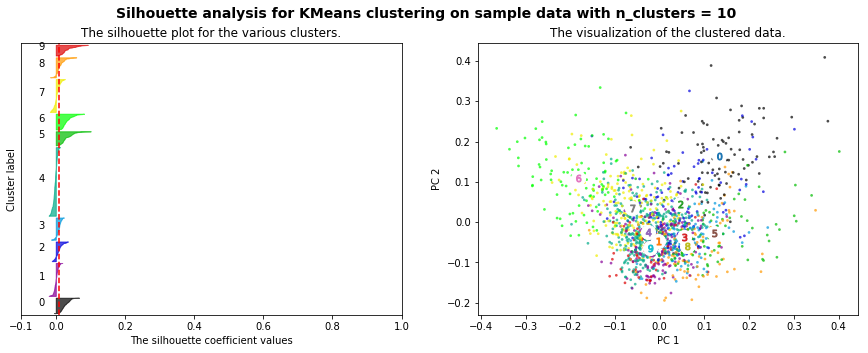

For n_clusters = 10, The average silhouette_score is : 0.009


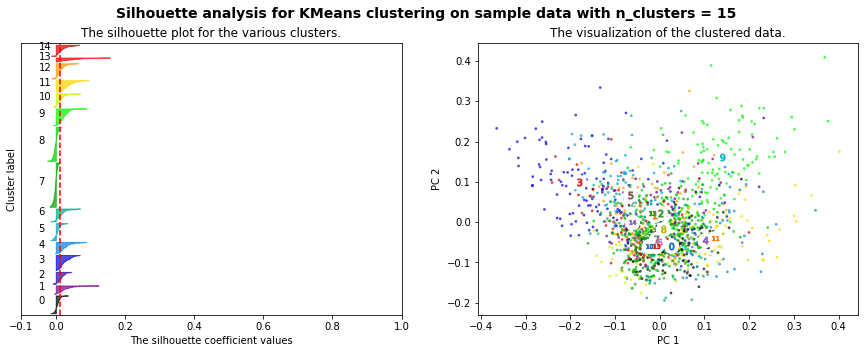

For n_clusters = 15, The average silhouette_score is : 0.012


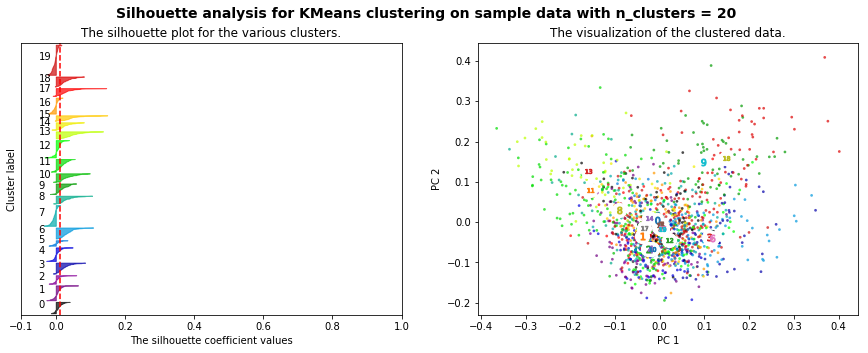

For n_clusters = 20, The average silhouette_score is : 0.013


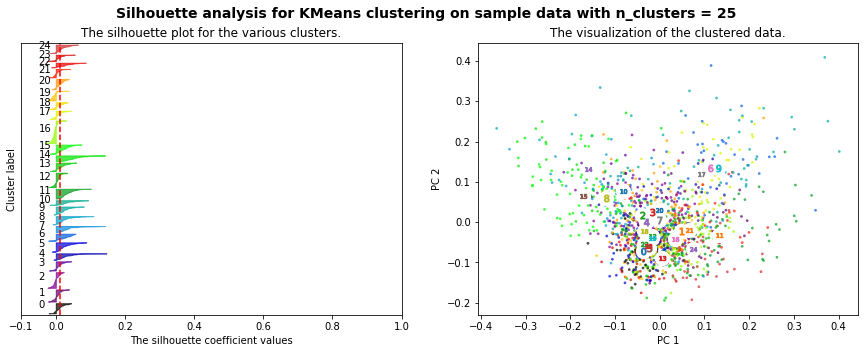

For n_clusters = 25, The average silhouette_score is : 0.014


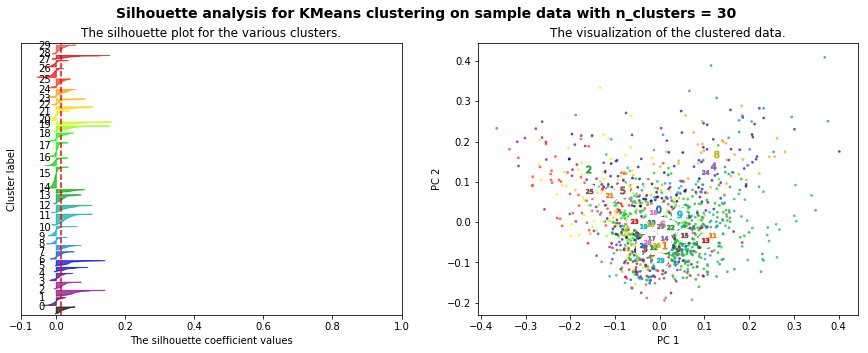

For n_clusters = 30, The average silhouette_score is : 0.014


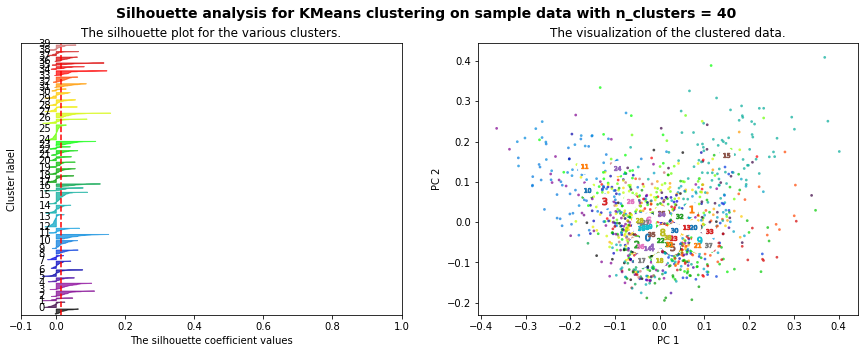

For n_clusters = 40, The average silhouette_score is : 0.014


In [45]:
#Next, I try to investigate the best number of clusters based on the textual data (there could be more dimensions)
#in the text even though we know that they come from five different topical sections. We indeed find that the 
#Silhouette score increases up to K values of about 25. We also find that when increasing K to high numbers, we
#see some very clear clusters while others are a lot less clear. In the early PCA's we can see some clear clusters but
#once we turn to ever higher values of K, the PCA's reduction to two dimensions becomes insufficient for the data
#structure.

pca = sklearn.decomposition.PCA(n_components = 2).fit(discussionTFVects.toarray())
reduced_data = pca.transform(discussionTFVects.toarray())

foo = discussionTFVects.toarray()
plotSilhouette(3, foo)
plotSilhouette(4, foo)
plotSilhouette(5, foo)
plotSilhouette(6, foo)
plotSilhouette(7, foo)
plotSilhouette(8, foo)
plotSilhouette(9, foo)
plotSilhouette(10, foo)
plotSilhouette(15, foo)
plotSilhouette(20, foo)
plotSilhouette(25, foo)
plotSilhouette(30, foo)
plotSilhouette(40, foo)

In [46]:
#While the previous analysis has suggested that there may be more dimensions in our data than the original five
#this is visually quite difficult to deal with. For now, I will thus continue with K=5 to test how well the K-means
#clustering approach can approximate the 'real' structure of the data.

targetDF = discussions
textColumn = 'Statement'
numCategories = 5

discussionKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
discussionKM.fit(discussionTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [47]:
#We see that all measures for comparing categorical variables or clusterings are a lot lower than when working with
#your exmaple corpus. Frankly, I wonder how you got to such high values. Below, I will compare this to hierachical 
#clustering approaches on my data.
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(discussions['topic'], discussionKM.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(discussions['topic'], discussionKM.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(discussions['topic'], discussionKM.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(discussions['topic'], discussionKM.labels_)))

For our clusters:
Homogeneity: 0.125
Completeness: 0.131
V-measure: 0.128
Adjusted Rand Score: 0.098


In [48]:
#Adding the kmeans clusters to my dataframe.
discussions['kmeans_k5'] = discussionKM.labels_
discussions[:10]

,Unnamed: 0,Statement,topic,wordcount,charcount,kmeans_k5
0,1,I also think get the immigrants jobs as soon ...,Immigration,37,225,3
1,2,I dont necessarily believe everyone will get ...,Immigration,44,225,4
2,3,"Regarding immigration, there will be more. We...",Immigration,41,225,4
3,4,Yeah. Just to maintain skills. You spend 15...,Gender,41,225,2
4,5,"Thats the question, though. We dont have mini...",Gender,41,225,0
5,6,Always gender/common sense?16:10 involved in ...,Gender,36,225,3
6,7,"What about working from home, then? You could...",Gender,40,225,1
7,8,But it's also about knowing what your priori...,Gender,43,225,3
8,9,"Like I was saying, the larger companies coul...",Gender,40,225,0
9,10,I dont think its so much less for the young b...,Generations,35,225,2


In [49]:
#Next, I inspect the word with the highest probability per topic. We can see that some topics are quite clear and
#approcimate the 'true' differentiation. For example CLuster 1 contains "women" "home" "leave" "men" "work" "women" 
#"children." This clearly mirrors the gender discussions. Other clusters like cluster 4 remain quite ambiguous.
terms = discussionTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = discussionKM.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 pay
 work
 state
 wage
 like
 tax
 pension
 years
 minimum
 dont


Cluster 1:
 women
 home
 men
 leave
 work
 woman
 children
 child
 man
 parental


Cluster 2:
 got
 going
 ve
 think
 people
 just
 know
 like
 pay
 money


Cluster 3:
 job
 education
 school
 jobs
 dont
 work
 know
 people
 language
 want


Cluster 4:
 people
 think
 need
 money
 don
 work
 come
 make
 country
 say




In [50]:
#As the silhouette scores suggested, higher values of K might lead to better clusterings. So I inspect that.
numCategories = 25
discussionKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
discussionKM.fit(discussionTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [51]:
#Inspecting the word lists for a fit with substantially increase K leads to a lot clearer micro clusters
#that were not visible before. For example topic 7 entails "language" "culture" "speak" "School." Clearly,
#this is a subtopic of our 5 topics and it thus turns out that our data is indeed more dimensional than we may
#have anticipated. However, there are also "trash" clusters that do not seem to have any coherent meaning at all.
#See for example cluster 8.
terms = discussionTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = discussionKM.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 good
 measure
 really
 think
 live
 people
 integration
 society
 time
 common


Cluster 1:
 dont
 know
 think
 want
 people
 thats
 im
 job
 like
 money


Cluster 2:
 country
 come
 denmark
 danish
 years
 people
 coming
 immigrants
 immigration
 refugees


Cluster 3:
 education
 schools
 school
 work
 academic
 dont
 start
 think
 people
 year


Cluster 4:
 like
 people
 different
 say
 things
 work
 young
 just
 time
 instance


Cluster 5:
 woman
 man
 work
 job
 mother
 family
 different
 women
 gender
 employer


Cluster 6:
 going
 think
 people
 theyre
 just
 youre
 pay
 like
 benefit
 coming


Cluster 7:
 language
 culture
 school
 norwegian
 speak
 learn
 teaching
 integration
 integrate
 german


Cluster 8:
 got
 a3
 youve
 theyve
 hour
 youre
 hours
 want
 theyre
 week


Cluster 9:
 need
 people
 just
 think
 social
 contribute
 immigration
 support
 want
 help


Cluster 10:
 leave
 home
 parental
 child
 women
 men
 stay
 maternity
 work
 c

In [52]:
numCategories = 5
discussionKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
discussionKM.fit(discussionTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

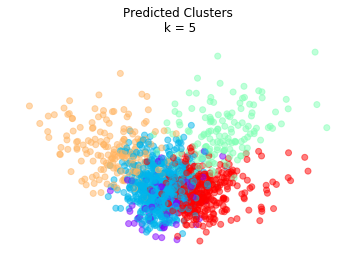

In [53]:
#Next I visualize the K = 5 fit with a PCA. We can see quite clear clusters.
discussionPCA = sklearn.decomposition.PCA(n_components = 2).fit(discussionTFVects.toarray())
reducedPCA_data = discussionPCA.transform(discussionTFVects.toarray())


colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in discussionKM.labels_]

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In [55]:
components = discussionPCA.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [56]:
colordict = {
'Gender': 'red',
'Immigration': 'orange',
'Labour market': 'green',
'Econ. Inequality': 'blue',
'Generations': 'purple'    
    }
colors = [colordict[c] for c in discussions['topic']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('Gender', 'red'), ('Immigration', 'orange'), ('Labour market', 'green'), ('Econ. Inequality', 'blue'), ('Generations', 'purple')])


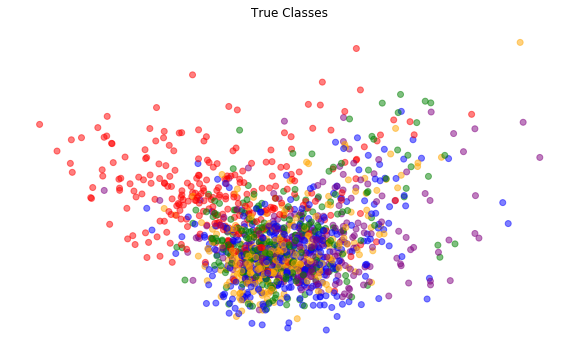

In [58]:
#Plotting the PCA results with the true clusters as dot colors shows what was already suggested earlier. Especially
#the gender topic "red" is approximated well by this clustering. Statements during other sections overlap.
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

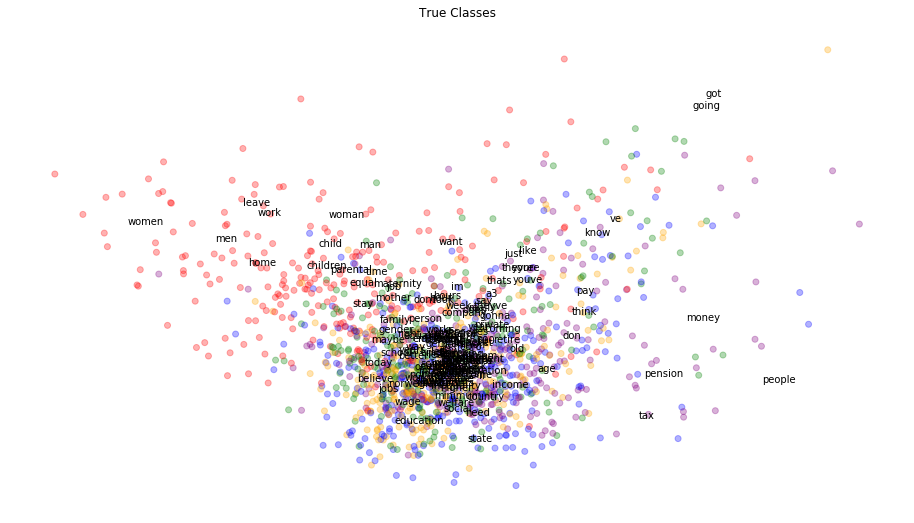

In [59]:
#Finally, I fold the wors into the PCA plot. Again, we see that the gender issue is differentiated from the rest
#with words like "women" or "leave" (which refers to parental leave from wotk). We also see "money," "pension," and 
#"tax" pulled to the lower right, terms that seem to belong to the blue economic inequality topic that concentrates
#in this region of the plot.
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [60]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [61]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [62]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/Users/Oscar/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [63]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [64]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [65]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/Users/Oscar/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[126.        , 193.        ,   0.        ,   2.        ],
       [195.        , 200.        ,   0.        ,   3.        ],
       [198.        , 201.        ,   0.        ,   4.        ],
       [  5.        , 202.        ,   0.37033177,   5.        ],
       [104.        , 169.        ,   0.40914841,   2.        ],
       [ 10.        ,  44.        ,   0.44134524,   2.        ],
       [ 49.        , 162.        ,   0.45096656,   2.        ],
       [151.        , 204.        ,   0.4553535 ,   3.        ],
       [117.        , 206.        ,   0.4650683 ,   3.        ],
       [  2.        ,  46.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

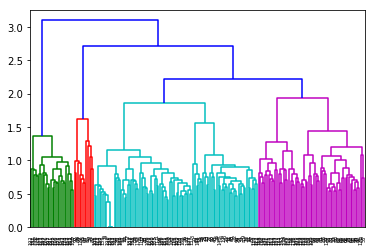

In [66]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

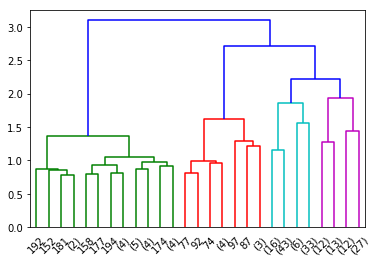

In [67]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [68]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4,
       3, 4, 2, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2,
       3, 2, 4, 4, 2, 4, 4, 4, 4, 2, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3, 1, 1,
       1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [69]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

/Users/Oscar/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [70]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,category,source_file,text,kmeans_predictions,wald_predictions
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ...",3,4
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...,3,4
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...,3,4
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom",3,4
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...,3,4
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David,3,4
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,3,4
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not...",3,4
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...,3,3
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...,3,4


# Now let's do it with our new data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [72]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())


/Users/Oscar/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/Users/Oscar/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

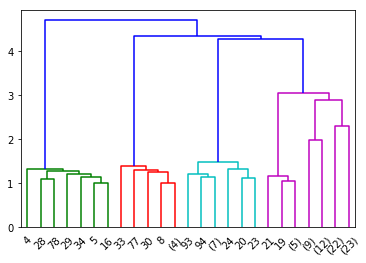

In [73]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [74]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

/Users/Oscar/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


As we only used one senator for this there isn't any point in looking at the metrics, but you should if possible

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

In [75]:
#First, I create two distance/similarity matrixes between documents, one based on coocurrence, the other based on 
#inverted cosine similarity.
#Create similarity matrix ward
discussionCoocMat = discussionTFVects * discussionTFVects.T
discussionCoocMat.setdiag(0)
discussion_linkage_matrix = scipy.cluster.hierarchy.ward(discussionCoocMat.toarray())
#Create similarity matrix cosine
discussionCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(discussionTFVects)
discussion_linkage_matrix_cos = scipy.cluster.hierarchy.ward(discussionCosinMat1)

/Users/Oscar/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/Users/Oscar/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


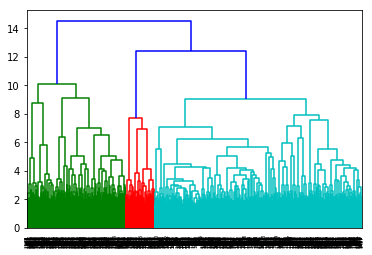

In [76]:
#Now, I fit a dendrogram on both these matrices.
#Dendrogram coocurrence.
dendrogramDat_cooc = scipy.cluster.hierarchy.dendrogram(discussion_linkage_matrix, p=100, truncate_mode='level', get_leaves=True)

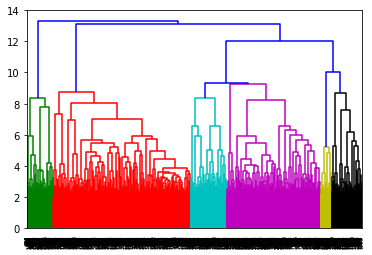

In [77]:
#The dendrogram based on cosine.
dendrogramDat_cos = scipy.cluster.hierarchy.dendrogram(discussion_linkage_matrix_cos, p=100, truncate_mode='level', get_leaves=True)

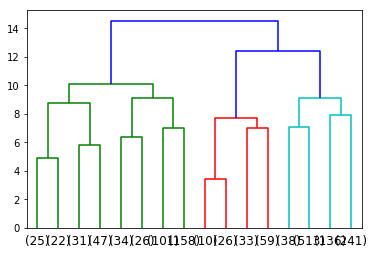

In [78]:
#The graphs are quite hard to interpret without. Therefore, I cut off the tree. We coult now look up some of these 
#documents but I look into that with the next step.
dendrogramDat = scipy.cluster.hierarchy.dendrogram(discussion_linkage_matrix, p=3, truncate_mode='level', get_leaves=True)

In [79]:
#Next, I hierarchically cluster the documents into 5 clusters (that is, I 'cut off' the tree after 4 branches).
#One clustering is based on cosines, the other on coocurrences. I add both clusterings to my matrix.
discussion_hierarchicalClusters = scipy.cluster.hierarchy.fcluster(discussion_linkage_matrix, 5, 'maxclust')
discussion_hierarchicalClusters_cos = scipy.cluster.hierarchy.fcluster(discussion_linkage_matrix_cos, 5, 'maxclust')

discussions['occurence_wald_predictions'] = discussion_hierarchicalClusters
discussions['cos_wald_predictions'] = discussion_hierarchicalClusters_cos
discussions[:10]

,Unnamed: 0,Statement,topic,wordcount,charcount,kmeans_k5,occurence_wald_predictions,cos_wald_predictions
0,1,I also think get the immigrants jobs as soon ...,Immigration,37,225,3,5,2
1,2,I dont necessarily believe everyone will get ...,Immigration,44,225,4,5,3
2,3,"Regarding immigration, there will be more. We...",Immigration,41,225,4,5,2
3,4,Yeah. Just to maintain skills. You spend 15...,Gender,41,225,2,5,3
4,5,"Thats the question, though. We dont have mini...",Gender,41,225,0,3,3
5,6,Always gender/common sense?16:10 involved in ...,Gender,36,225,3,5,2
6,7,"What about working from home, then? You could...",Gender,40,225,1,4,1
7,8,But it's also about knowing what your priori...,Gender,43,225,3,5,3
8,9,"Like I was saying, the larger companies coul...",Gender,40,225,0,5,5
9,10,I dont think its so much less for the young b...,Generations,35,225,2,5,5


In [80]:
#Next, I compare all 3 clustering with K=5 based on a variety of measures like Homogeneity or Rand score.
#The K-means approach does best in approcimateing the actual cluster structure in all measures.
#This is likely the case because the K-means approch leads to a global optimum while the other approaches 
#always partition the data and therefore waste ifnormation.

##The clusterings based on the cooccurrence matrices are also better at approximating the real 
#structure than the one based on cosine.
print("For K-means approach:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(discussions['topic'], discussionKM.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(discussions['topic'], discussionKM.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(discussions['topic'], discussionKM.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(discussions['topic'], discussionKM.labels_)))
print("")
print("For Hierarchical clustering based on cooccurrence:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(discussions['topic'], discussion_hierarchicalClusters)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(discussions['topic'], discussion_hierarchicalClusters)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(discussions['topic'], discussion_hierarchicalClusters)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(discussions['topic'], discussion_hierarchicalClusters)))
print("")
print("For Hierarchical clustering based on cosine:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(discussions['topic'], discussion_hierarchicalClusters_cos)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(discussions['topic'], discussion_hierarchicalClusters_cos)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(discussions['topic'], discussion_hierarchicalClusters_cos)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(discussions['topic'], discussion_hierarchicalClusters_cos)))

For K-means approach:
Homogeneity: 0.149
Completeness: 0.177
V-measure: 0.162
Adjusted Rand Score: 0.103

For Hierarchical clustering based on cooccurrence:
Homogeneity: 0.083
Completeness: 0.116
V-measure: 0.097
Adjusted Rand Score: 0.039

For Hierarchical clustering based on cosine:
Homogeneity: 0.066
Completeness: 0.084
V-measure: 0.074
Adjusted Rand Score: 0.027


# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [81]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: nltk.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, contact, meli..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, washington, c..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, surpris, amer..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immedi, releas, washington, c, today, senat, ..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immedi, releas, veteran, day, america, stand,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, mr, chairman,..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immedi, releas, washington, c, senat, edward,..."


In [82]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [83]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [84]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [85]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [86]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [87]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(7, 0.9691115)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [88]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [89]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(1, 0.9568327)]",0.000000,0.956833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
101,02Feb2007Kennedy10.txt,"[(7, 0.9922584)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.992258,0.0,0.0
201,04May2006Kennedy8.txt,"[(4, 0.5079096), (7, 0.48947328)]",0.000000,0.000000,0.000000,0.000000,0.507910,0.000000,0.000000,0.489473,0.0,0.0
301,06Jun2007Kennedy1.txt,"[(2, 0.062742956), (7, 0.9348695)]",0.000000,0.000000,0.062743,0.000000,0.000000,0.000000,0.000000,0.934870,0.0,0.0
401,08Feb2005Kennedy0.txt,"[(1, 0.16932303), (3, 0.21954584), (6, 0.60279...",0.000000,0.169323,0.000000,0.219546,0.000000,0.000000,0.602796,0.000000,0.0,0.0
501,09Nov2005Kennedy11.txt,"[(6, 0.9372469)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.937247,0.000000,0.0,0.0
601,11Nov2005Kennedy6.txt,"[(0, 0.95850176)]",0.958502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
701,13Jun2006Kennedy1.txt,"[(6, 0.051299345), (7, 0.9451422)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051299,0.945142,0.0,0.0
801,15Dec2005Kennedy5.txt,"[(1, 0.89867973), (4, 0.022453912), (5, 0.0282...",0.000000,0.898680,0.000000,0.000000,0.022454,0.028229,0.049159,0.000000,0.0,0.0
901,16May2007Kennedy5.txt,"[(1, 0.95683426)]",0.000000,0.956834,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [90]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.969112,0.000000,0.0
1,0.0,0.956833,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
2,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.991070,0.0
3,0.0,0.000000,0.000000,0.460636,0.0,0.000000,0.0,0.531918,0.000000,0.0
4,0.0,0.000000,0.052089,0.021456,0.0,0.000000,0.0,0.000000,0.923992,0.0
5,0.0,0.000000,0.000000,0.000000,0.0,0.140806,0.0,0.000000,0.850908,0.0
6,0.0,0.981563,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
7,0.0,0.000000,0.000000,0.950434,0.0,0.016212,0.0,0.000000,0.000000,0.0
8,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.994789,0.0
9,0.0,0.000000,0.650383,0.000000,0.0,0.000000,0.0,0.000000,0.319108,0.0


First we can visualize as a stacked bar chart:

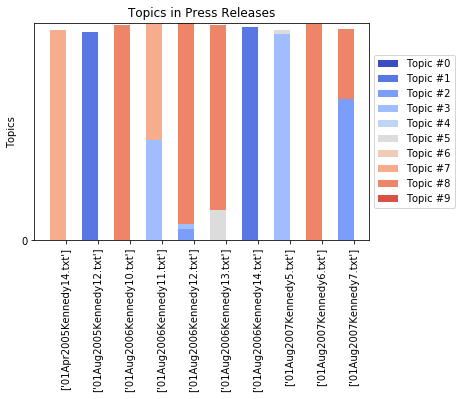

In [91]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

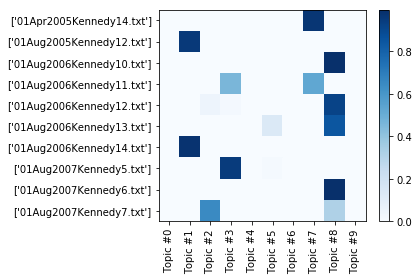

In [92]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [93]:
senlda.show_topic(1)

[('head', 0.018759163),
 ('fund', 0.016657028),
 ('worker', 0.010516731),
 ('wagon', 0.007945579),
 ('import', 0.0073026675),
 ('pension', 0.0069454177),
 ('standard', 0.006247591),
 ('commit', 0.0059612445),
 ('loan', 0.00590974),
 ('effect', 0.0059047057)]

And if we want to make a dataFrame:

In [94]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,teacher,head,govern,worker,fund,worker,fund,import,loan,loan
1,fund,fund,worker,fund,worker,fund,worker,troop,wage,author
2,worker,worker,loan,depart,victim,wage,troop,worker,lender,lender
3,author,wagon,import,pension,employ,minimum,heat,wagon,minimum,question
4,unit,import,wagon,govern,pension,wagon,govern,inform,worker,troop
5,depart,pension,employ,import,patient,import,wagon,fund,depart,govern
6,wagon,standard,unit,inform,wage,victim,liheap,govern,wagon,import
7,wage,commit,head,fda,wagon,unit,winter,loan,fund,borrow
8,import,loan,commit,wagon,medicaid,chip,import,assist,employ,mental
9,effect,effect,amend,author,save,citizen,assist,iraqi,mental,fund


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

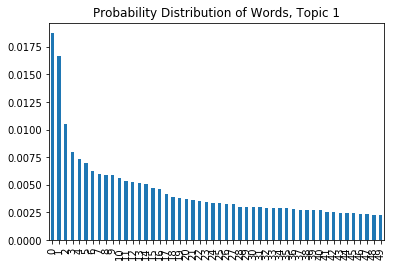

In [95]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [96]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

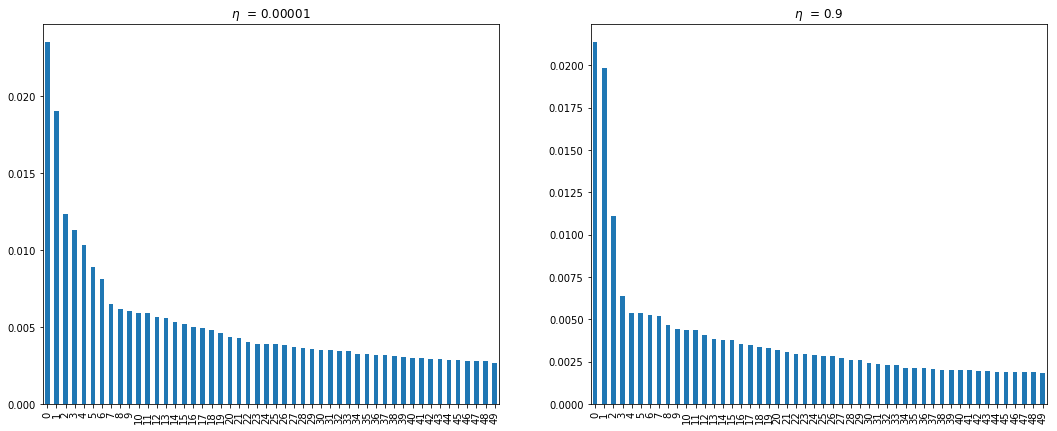

In [97]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [102]:
#First I follow the preprocessing steps that you did above.
discussions['tokenized_text'] = discussions['Statement'].apply(lambda x: nltk.word_tokenize(x))
discussions['normalized_tokens'] = discussions['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

discussions['reduced_tokens'] = discussions['normalized_tokens'].apply(lambda x: dropMissing(x, discussionTFVectorizer.vocabulary_.keys()))

dictionary = gensim.corpora.Dictionary(discussions['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in discussions['reduced_tokens']]
gensim.corpora.MmCorpus.serialize('discussions.mm', corpus)
discussionsmm = gensim.corpora.MmCorpus('discussions.mm')

In [103]:
#Now, I fit my first LDA with K = 5 and alpha and eta set to auto.
disclda_5_auto = gensim.models.ldamodel.LdaModel(corpus=discussionsmm, id2word=dictionary, num_topics=5, alpha='auto', eta='auto')

In [104]:
#Next, I inspect the words for each topic that have the highest prevalence. We can see that these do not distinguish
#the clusters very well. That is because certain words are simply very frequent throughout the corpus. A better
#measure to immediately disambiguate topics is the FREX score that balances Frequency and Exclusivity of a term per 
#topic.
topicsDict = {}
for topicNum in range(disclda_5_auto.num_topics):
    topicWords = [w for w, p in disclda_5_auto.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,think,think,work,work,work
1,work,work,pension,wage,pay
2,need,job,thing,like,know
3,pay,like,say,know,think
4,person,thing,money,money,want
5,month,say,benefit,state,year
6,employ,need,make,need,job
7,time,school,pay,got,dont
8,money,time,children,pay,come
9,thing,want,like,dont,say


In [105]:
#Next, I run models with K=10 and K=20. The probability lists show that this somewhat disambiguates the topics better.
#Still, there is a lot of overlap though.
disclda_10_auto = gensim.models.ldamodel.LdaModel(corpus=discussionsmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')
disclda_20_auto = gensim.models.ldamodel.LdaModel(corpus=discussionsmm, id2word=dictionary, num_topics=20, alpha='auto', eta='auto')

In [106]:
topicsDict = {}
for topicNum in range(disclda_10_auto.num_topics):
    topicWords = [w for w, p in disclda_10_auto.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF_10_auto = pandas.DataFrame(topicsDict)
wordRanksDF_10_auto

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,home,work,need,think,work,work,work,think,state,money
1,work,know,work,work,need,pay,know,tax,got,know
2,like,need,pay,like,pension,job,say,dont,think,pay
3,come,like,year,pay,year,person,thing,school,job,make
4,think,job,think,say,want,money,think,women,benefit,tax
5,year,think,like,dont,say,wage,wage,know,wage,pension
6,know,money,person,thing,come,thing,money,year,work,year
7,say,make,paid,way,job,certain,women,work,pay,employ
8,school,want,want,job,think,say,person,pay,like,time
9,stay,talk,parent,want,time,women,got,thing,make,dont


In [108]:
topicsDict = {}
for topicNum in range(disclda_20_auto.num_topics):
    topicWords = [w for w, p in disclda_20_auto.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF_20_auto = pandas.DataFrame(topicsDict)
wordRanksDF_20_auto

,Topic_0,Topic_1,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,come,work,work,pay,think,pay,work,think,work,work,say,like,work,job,think,work,thing,work,work,think
1,know,job,pension,think,work,want,money,need,think,think,need,need,thing,employ,pension,tax,work,thing,think,work
2,work,equal,think,work,want,say,year,pay,worker,month,work,say,like,know,pay,say,certain,year,home,like
3,look,women,say,job,benefit,money,pay,like,want,need,way,talk,job,think,time,make,dont,know,job,say
4,need,want,dont,like,tax,think,think,school,like,like,pension,state,time,year,thing,job,think,dont,need,want
5,thing,need,know,got,women,mean,child,state,employ,person,help,money,come,work,children,money,know,like,like,year
6,think,pay,children,pension,say,need,say,job,union,come,money,thing,pay,way,know,think,need,think,time,make
7,like,employ,make,want,got,home,dont,say,dont,year,make,pay,know,school,problem,pay,say,make,women,term
8,say,better,wage,tax,children,know,state,home,know,time,come,dont,dont,women,want,state,job,need,know,thing
9,pension,men,time,talk,thing,right,like,im,need,pay,school,want,think,parent,like,earn,year,tax,pay,dont


In [109]:
ldaDF = pandas.DataFrame({
        'name' : discussions['Unnamed: 0'],
        'topics' : [disclda_5_auto[dictionary.doc2bow(l)] for l in discussions['reduced_tokens']]
    })

In [110]:
topicsProbDict = {i : [0] * len(ldaDF) for i in range(disclda_5_auto.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(disclda_5_auto.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

In [111]:
#Add up to 1.
ldaDFV = ldaDF[:50][['topic_%d' %x for x in range(5)]]
ldaDFVisN = ldaDF[:50][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)

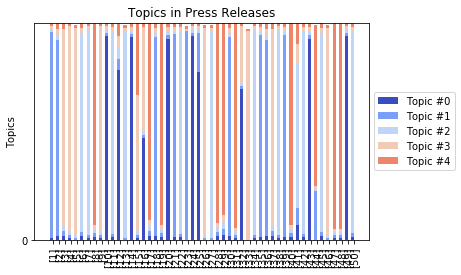

In [112]:
#Next, I show the distributions of some example documents over topics.
#Something clearly went wront in the second graph for K=20 model because the values do not add up to one.
#Nevertheless, we can see that lower values of K seem to lead to a less unambiguous assignment. Documents
#are mostly assigned to one topic. However, upon increasing K, we see that more documents are a complex mixture of many 
#topics.
N = 50
ind = np.arange(N)
K = disclda_5_auto.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')
plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')
plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

In [115]:
ldaDF = pandas.DataFrame({
        'name' : discussions['Unnamed: 0'],
        'topics' : [disclda_20_auto[dictionary.doc2bow(l)] for l in discussions['reduced_tokens']]
    })

topicsProbDict = {i : [0] * len(ldaDF) for i in range(disclda_20_auto.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(disclda_20_auto.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDFV = ldaDF[:50][['topic_%d' %x for x in range(20)]]
ldaDFVisN = ldaDF[:50][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)

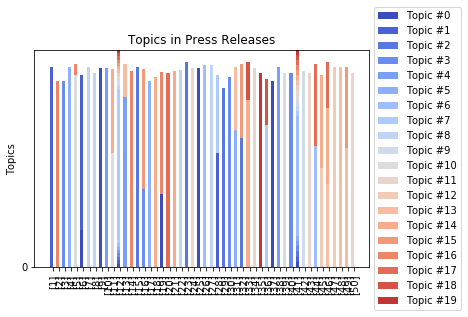

In [114]:
N = 50
ind = np.arange(N)
K = disclda_20_auto.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')
plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')
plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
plt.show()

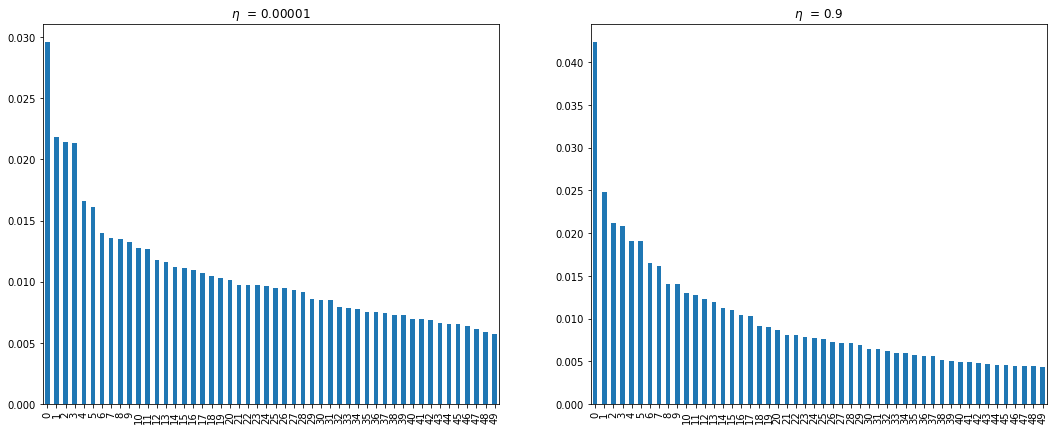

In [118]:
#Next I compare the probability disctribution over words for different values of eta.
#Similar to your results above, we see that a higher eta value lead to a flatter probability distribution over words.
disclda_10_e00 = gensim.models.ldamodel.LdaModel(corpus=discussionsmm, id2word=dictionary, num_topics=10, eta = 0.00001)
disclda_10_e09 = gensim.models.ldamodel.LdaModel(corpus=discussionsmm, id2word=dictionary, num_topics=10, eta = 0.9)


disclda_10_e00_df = pandas.DataFrame(disclda_10_e00.show_topic(1, topn=50))
disclda_10_e09_df = pandas.DataFrame(disclda_10_e09.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
disclda_10_e00_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
disclda_10_e09_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

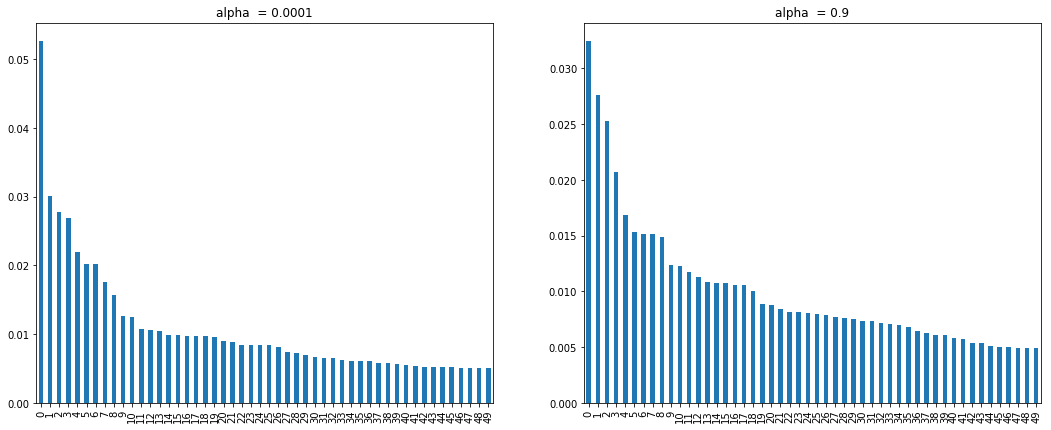

In [116]:
#The same is the case for lower values of alpha.
disclda_10_eauto_a01 = gensim.models.ldamodel.LdaModel(corpus=discussionsmm, id2word=dictionary, num_topics=10, eta = 'auto', alpha=.01)
disclda_10_eauto_a08 = gensim.models.ldamodel.LdaModel(corpus=discussionsmm, id2word=dictionary, num_topics=10, eta = 'auto', alpha=.8)

disclda_10_eauto_a01_df = pandas.DataFrame(disclda_10_eauto_a01.show_topic(1, topn=50))
disclda_10_eauto_a08_df = pandas.DataFrame(disclda_10_eauto_a08.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
disclda_10_eauto_a01_df.plot.bar(legend = False, ax = ax1, title = 'alpha  = 0.0001')
disclda_10_eauto_a08_df.plot.bar(legend = False, ax = ax2, title = 'alpha  = 0.9')
plt.show()

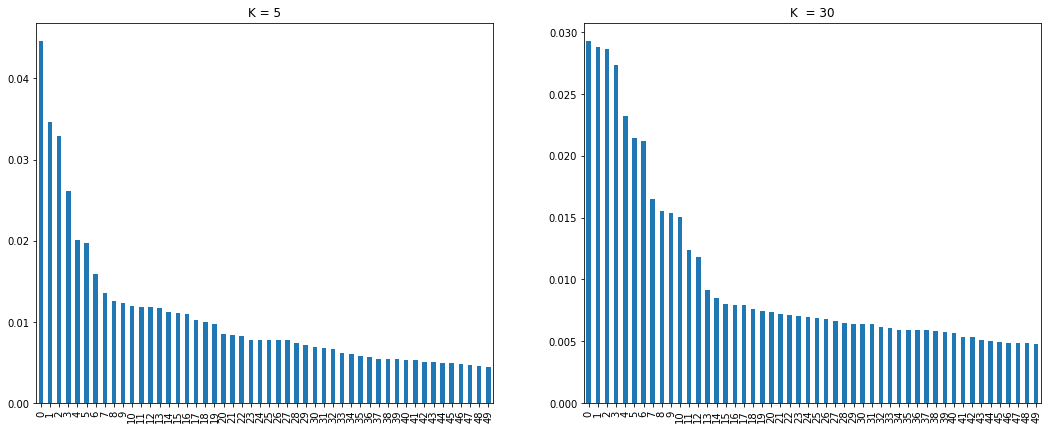

In [117]:
#Finally, K also plays a role regarding the probabilty distribution over words. Again, higher values
#of K lead to a more flattened out distributon over words.
disclda_5_auto = gensim.models.ldamodel.LdaModel(corpus=discussionsmm, id2word=dictionary, num_topics=5, eta =.2, alpha =.2)
disclda_30_auto = gensim.models.ldamodel.LdaModel(corpus=discussionsmm, id2word=dictionary, num_topics=30, eta =.2, alpha =.2)


disclda_5_auto_df = pandas.DataFrame(disclda_5_auto.show_topic(1, topn=50))
disclda_30_df = pandas.DataFrame(disclda_30_auto.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
disclda_5_auto_df.plot.bar(legend = False, ax = ax1, title = 'K = 5')
disclda_30_df.plot.bar(legend = False, ax = ax2, title = 'K  = 30')
plt.show()